In [287]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
import time
from datetime import datetime, timedelta
import pandas as pd
import urllib.request
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sqlalchemy import create_engine, Table, Column, Integer, String, MetaData
import cx_Oracle
from sqlalchemy import create_engine
import seaborn as sns
sns.set_style('whitegrid')
import pyecharts as pye
from pyecharts import options as opts
from pyecharts.charts import Line
from pyecharts.charts import Timeline, Bar, Line ,Grid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from IPython.display import IFrame
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [288]:
from matplotlib import font_manager,rc
# 한글 폰트
font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [289]:
username = 'base_man'
password = '1111'
hostname = '192.168.0.29'
port = '1521'
service_name = 'XE'

# 연결 문자열 작성
dsn = cx_Oracle.makedsn(hostname, port, service_name=service_name)
connection_string = f'oracle+cx_oracle://{username}:{password}@{dsn}'

# SQLAlchemy 엔진 생성
engine = create_engine(connection_string)

In [290]:
query = "SELECT * FROM holiday"

# 데이터베이스에서 데이터프레임으로 읽기
df2 = pd.read_sql(query, con=engine)
df2.head()

,이름,공휴일
0,1월1일,2022-01-01
1,설날,2022-01-31
2,설날,2022-02-01
3,설날,2022-02-02
4,삼일절,2022-03-01


In [291]:
query = "SELECT * FROM crowd"

# 데이터베이스에서 데이터프레임으로 읽기
df = pd.read_sql(query, con=engine)
df.head()

,날짜,요일,홈,방문,구장,관중수,년,월,일,평균기온,최저기온,최고기온,일강수량,평균_상대습도,주말
0,2023-06-07,Wednesday,삼성,NC,대구,7119,2023,6,7,24.1,18.4,29.4,0.0,58.1,0
1,2023-06-08,Thursday,삼성,NC,대구,5989,2023,6,8,24.1,20.1,29.3,0.0,57.8,0
2,2023-06-09,Friday,삼성,롯데,대구,15893,2023,6,9,24.6,18.6,31.0,0.0,50.4,0
3,2023-06-10,Saturday,삼성,롯데,대구,24000,2023,6,10,24.5,18.6,31.5,0.0,61.0,1
4,2023-06-11,Sunday,삼성,롯데,대구,18496,2023,6,11,24.6,20.3,30.6,0.0,66.5,1


In [292]:
df2 = df2.rename(columns={'공휴일' : '날짜'})
df2 = df2.rename(columns={'이름' : 'holiday'})
df2.head()

,holiday,날짜
0,1월1일,2022-01-01
1,설날,2022-01-31
2,설날,2022-02-01
3,설날,2022-02-02
4,삼일절,2022-03-01


In [293]:
# 시계열 데이터와 공휴일 데이터 병합
df = pd.merge(df, df2, on='날짜', how='left')

# 휴일 여부를 나타내는 피처 추가
df['휴일여부'] = df['holiday'].notna().astype(int)

In [294]:
weeks_dummy = pd.get_dummies(df.요일, drop_first=False)
data = pd.concat([df, weeks_dummy],axis=1)

In [295]:
pd.concat([df['요일'].head(), weeks_dummy.head()], axis=1)

,요일,Friday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Wednesday,False,False,False,False,False,True
1,Thursday,False,False,False,True,False,False
2,Friday,True,False,False,False,False,False
3,Saturday,False,True,False,False,False,False
4,Sunday,False,False,True,False,False,False


In [296]:
# data = data.drop(['요일','방문','구장','년','월','일','홈','holiday','주말','Friday','Saturday','Sunday','Thursday','Tuesday','Wednesday','휴일여부'], axis=1)
data = data.drop(['요일','방문','구장','년','월','일','홈','holiday','주말','Tuesday','Wednesday','Thursday','Friday'], axis=1)

In [297]:
data.head()

,날짜,관중수,평균기온,최저기온,최고기온,일강수량,평균_상대습도,휴일여부,Saturday,Sunday
0,2023-06-07,7119,24.1,18.4,29.4,0.0,58.1,0,False,False
1,2023-06-08,5989,24.1,20.1,29.3,0.0,57.8,0,False,False
2,2023-06-09,15893,24.6,18.6,31.0,0.0,50.4,0,False,False
3,2023-06-10,24000,24.5,18.6,31.5,0.0,61.0,0,True,False
4,2023-06-11,18496,24.6,20.3,30.6,0.0,66.5,0,False,True


In [298]:
data = data.set_index('날짜')

In [299]:
train_input, test_input, train_target, test_target = train_test_split(data[data.columns.difference(['관중수'])], data['관중수'],test_size=0.3, random_state=100)

In [300]:
from sklearn.metrics import mean_squared_error
# 모델 초기화
model = LinearRegression()

# 모델 학습
model.fit(train_input, train_target)  # train_input과 train_target을 사용

# 예측
y_pred = model.predict(test_input)  # test_input으로 예측 수행

# 평가
mse = mean_squared_error(test_target, y_pred)  # test_target과 y_pred를 비교
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 32762243.536361627


In [301]:
poly = PolynomialFeatures()

poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)
ss = StandardScaler() # 표준화 작업을 함수로서 지원
ss.fit(train_poly)

train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)
from sklearn.linear_model import Lasso
# 데이터 수집
# 데이터 전처리
lasso = Lasso()
# 훈련데이터셋, 시험데이터셋 분리
lasso.fit(train_scaled, train_target)
lasso_pred = lasso.predict(test_scaled)
optimal_alpha = 100
lasso_optimal = Lasso(alpha=optimal_alpha, max_iter=1000)
lasso_optimal.fit(train_scaled, train_target)

# 예측값
y_test_pred = lasso_optimal.predict(test_scaled)

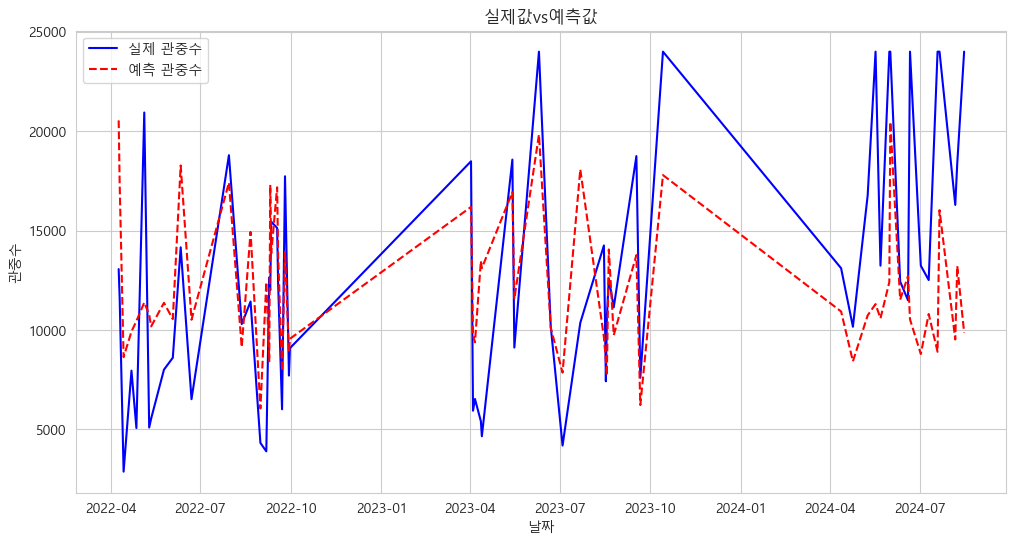

In [302]:
# 최적의 alpha 값으로 모델 학습
lasso_final = Lasso(alpha=optimal_alpha,max_iter=1000)
lasso_final.fit(train_scaled, train_target)

# 테스트 데이터에 대한 예측
final_predictions = lasso_final.predict(test_scaled)

# 테스트 인덱스를 기준으로 정렬 (인덱스가 없으면 이 단계는 생략해도 됨)
sorted_indices = np.argsort(test_target.index)
sorted_test_target = test_target.iloc[sorted_indices]
sorted_predictions = final_predictions[sorted_indices]

# 시각화
plt.figure(figsize=(12, 6))

# 실제값과 예측값의 선 그래프
plt.plot(sorted_test_target.index, sorted_test_target, label='실제 관중수', color='blue')
plt.plot(sorted_test_target.index, sorted_predictions, label='예측 관중수', color='red', linestyle='--')

plt.xlabel('날짜')
plt.ylabel('관중수')
plt.title(f'실제값vs예측값')
plt.legend()
plt.grid(True)
plt.show()

In [139]:
# data = data.drop(['요일','방문','구장','년','월','일','홈','holiday','평균기온','최저기온','최고기온','일강수량','평균_상대습도','휴일여부'], axis=1)
data = data.drop(['요일','방문','구장','년','월','일','홈','holiday','평균기온','최저기온','최고기온','일강수량','평균_상대습도','휴일여부','주말'], axis=1)

In [140]:
data = data.set_index('날짜')

In [141]:
train_input, test_input, train_target, test_target = train_test_split(data[data.columns.difference(['관중수'])], data['관중수'],test_size=0.3, random_state=100)

In [142]:
from sklearn.metrics import mean_squared_error
# 모델 초기화
model = LinearRegression()

# 모델 학습
model.fit(train_input, train_target)  # train_input과 train_target을 사용

# 예측
y_pred = model.predict(test_input)  # test_input으로 예측 수행

# 평가
mse = mean_squared_error(test_target, y_pred)  # test_target과 y_pred를 비교
print(f'Mean Squared Error: {mse}')
poly = PolynomialFeatures()

poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)
ss = StandardScaler() # 표준화 작업을 함수로서 지원
ss.fit(train_poly)

train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)
from sklearn.linear_model import Lasso
# 데이터 수집
# 데이터 전처리
lasso = Lasso()
# 훈련데이터셋, 시험데이터셋 분리
lasso.fit(train_scaled, train_target)
lasso_pred = lasso.predict(test_scaled)
optimal_alpha = 100
lasso_optimal = Lasso(alpha=optimal_alpha, max_iter=1000)
lasso_optimal.fit(train_scaled, train_target)

# 예측값
y_test_pred = lasso_optimal.predict(test_scaled)

Mean Squared Error: 30773930.295519203


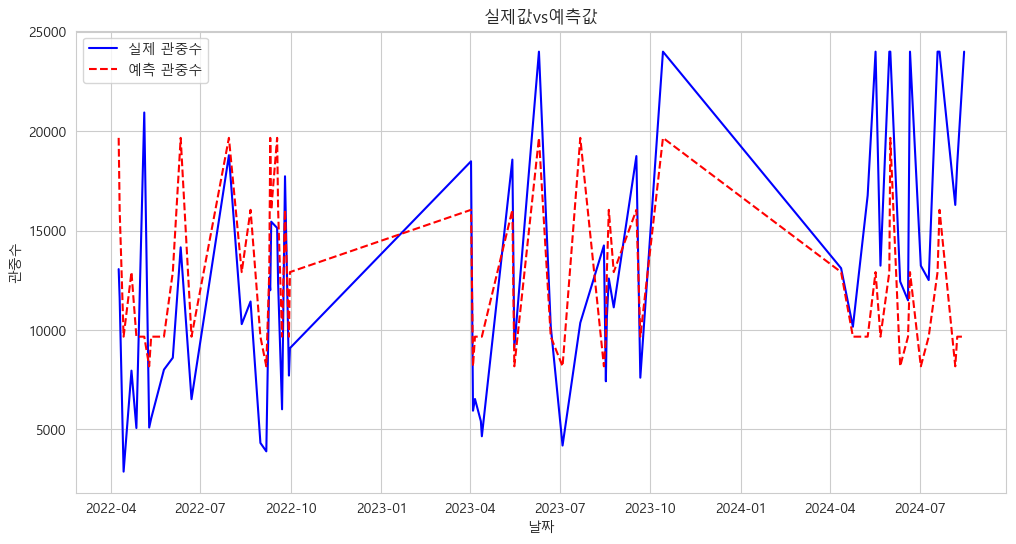

In [44]:
# 최적의 alpha 값으로 모델 학습
lasso_final = Lasso(alpha=optimal_alpha,max_iter=1000)
lasso_final.fit(train_scaled, train_target)

# 테스트 데이터에 대한 예측
final_predictions = lasso_final.predict(test_scaled)

# 테스트 인덱스를 기준으로 정렬 (인덱스가 없으면 이 단계는 생략해도 됨)
sorted_indices = np.argsort(test_target.index)
sorted_test_target = test_target.iloc[sorted_indices]
sorted_predictions = final_predictions[sorted_indices]

# 시각화
plt.figure(figsize=(12, 6))

# 실제값과 예측값의 선 그래프
plt.plot(sorted_test_target.index, sorted_test_target, label='실제 관중수', color='blue')
plt.plot(sorted_test_target.index, sorted_predictions, label='예측 관중수', color='red', linestyle='--')

plt.xlabel('날짜')
plt.ylabel('관중수')
plt.title(f'실제값vs예측값')
plt.legend()
plt.grid(True)
plt.show()